<a href="https://colab.research.google.com/github/VinayakGupta112/Projects/blob/main/Is_it_a_Tumor%3F_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it a tumor?

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
!pip install -U requests
import requests
print("IMPORTED VERSION IS ", requests.__version__)
from requests.exceptions import JSONDecodeError
print("NOW OKAY")

IMPORTED VERSION IS  2.32.3
NOW OKAY


In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](attachment:a0483178-c30e-4fdd-b2c2-349e130ab260.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of affected and not affected mammograms

In [ ]:
!pip install duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.9 MB/s eta 0:00:00


In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    ddg = DDGS()
    results = []

    for result in ddg.images(term, max_results=max_images):
        results.append(result['image'])

    return L(results)

Let's start by searching for a affected photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('tumor affected mammogram photos', max_images=1)
urls[0]

Searching for 'tumor affected mammogram photos'


'https://www.rad-imaging.com/wp-content/uploads/2017/07/tomo-image-idc.jpg'

...and then download a URL and take a look at it:

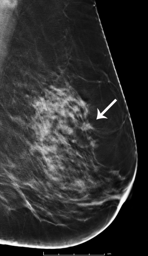

In [ ]:
from fastdownload import download_url
dest = 'mam.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "healthy mammogram photos":

Searching for 'not affected mammogram photos'


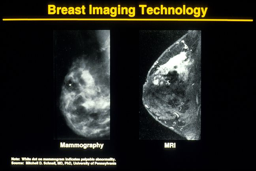

In [ ]:
download_url(search_images('not affected mammogram photos', max_images=1)[0], 'Not_affected.jpg', show_progress=False)
Image.open('Not_affected.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "affected mammogram photo" and "unaffected mammogram photo" photos, and save each group of photos to a different folder.

In [ ]:
searches = 'not affected mammogram','tumor affected mammogram'
path = Path('tumor_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'not affected mammogram photo'
Searching for 'tumor affected mammogram photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

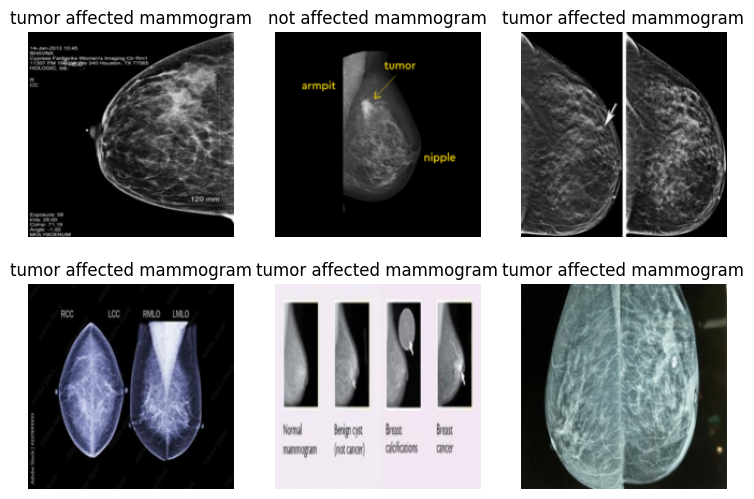

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "affected" or "not affected").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *affected* or *not affected*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.981493,1.992077,0.444444,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.049600,1.535378,0.333333,00:08
1,1.049336,1.101263,0.333333,00:07
2,0.897613,0.892836,0.333333,00:09


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use the model!!

Let's see what our model thinks about that mammogram we downloaded at the start:

In [ ]:
is_tumor,_,probs = learn.predict(PILImage.create('mam.jpg'))
print(f"This is a: {is_tumor}.")
print(f"Probability it's a tumor: {probs[0]:.4f}")

This is a: not affected mammogram.
Probability it's a tumor: 0.9936


## Result and Conclusions

The model can recognize a tumor and learn from the dataset but based off of a very small data there are some errors which it is facing like even though it is predicting that the mammogram is unaffected the probability of it having a tumor is .9936!!